### Transfer learning for Kaggle 120 dog breeds challenge
The goal for this project is to apply transfer learning using Pytorch to classify 120 dog breeds available on a Kaggle identification challenge (https://www.kaggle.com/c/dog-breed-identification). <br>

Ths notebook was based on Will Koehrsen Medium Article "Transfer Learning with Convolutional Network in Pytorch".(https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce)

In [2]:
!pip install torchsummary

In [3]:
from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns
# PyTorch
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data science tools
import numpy as np
import pandas as pd
import os

# Image manipulations
from PIL import Image
# Useful for examining network
from torchsummary import summary
# Timing utility
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

# Printing out all outputs
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
pwd

'/home/workspace/deep-learning-v2-pytorch/FINAL_PROJECT'

In [4]:
ls

extract_zipped_folder.ipynb  Transfer_learning_nb_Will_Koehrsen_resnet50.ipynb
models.csv                   Transfer_learning_nb_Will_Koehrsen_vgg16.ipynb
train_test_valid/            vgg16-transfer-4.pt
train_test_valid.zip         vgg16-transfer-4.pth


In [4]:
# Spliting the Dataset
datadir = "/home/workspace/deep-learning-v2-pytorch/FINAL_PROJECT/train_test_valid/"

In [5]:
os.listdir(datadir)

['test', 'train', 'valid']

In [21]:
import os
import shutil
os.chdir(datadir)

In [11]:
ls

extract_zipped_folder.ipynb  train_test_validate.zip
train_test_validate/         Transfer_learning_nb_Will_Koehrsen.ipynb


In [16]:
for folder in os.listdir('.'):
    counter = 0
    for file in os.listdir(folder):
        if counter < 20:
            if not os.path.isdir(f'../train_test_validate/test/{folder}'):
                os.mkdir(f'../train_test_validate/test/{folder}')
            shutil.copy(f'{folder}/{file}', f'../train_test_validate/test/{folder}/{file}')
            counter += 1
        elif counter < 30:
            if not os.path.isdir(f'../train_test_validate/valid/{folder}'):
                os.mkdir(f'../train_test_validate/valid/{folder}')
            shutil.copy(f'{folder}/{file}', f'../train_test_validate/valid/{folder}/{file}')
            counter += 1
        else:
            if not os.path.isdir(f'../train_test_validate/train/{folder}'):
                os.mkdir(f'../train_test_validate/train/{folder}')
            shutil.copy(f'{folder}/{file}', f'../train_test_validate/train/{folder}/{file}')
        

In [6]:
# Location of data
datadir = "/home/workspace/deep-learning-v2-pytorch/FINAL_PROJECT/train_test_valid/"
traindir = datadir + 'train/'
validdir = datadir + 'valid/'
testdir = datadir + 'test/'

save_file_name = 'vgg16-transfer-stanford.pt'
checkpoint_path = 'vgg16-transfer-stanford.pth'

# Change to fit hardware
batch_size = 128

# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: True
1 gpus detected.


In [31]:
# Check on the structure from the train, test and validate folders
#!tree

In [8]:
ls

extract_zipped_folder.ipynb  train_test_validate.zip
train_test_validate/         Transfer_learning_nb_Will_Koehrsen.ipynb


In [7]:
# Empty lists
categories = []
img_categories = []
n_train = []
n_valid = []
n_test = []
hs = []
ws = []

# Iterate through each category
for d in os.listdir(traindir):
    categories.append(d)

    # Number of each image
    train_imgs = os.listdir(traindir + d)
    valid_imgs = os.listdir(validdir + d)
    test_imgs = os.listdir(testdir + d)
    n_train.append(len(train_imgs))
    n_valid.append(len(valid_imgs))
    n_test.append(len(test_imgs))

    # Find stats for train images
    for i in train_imgs:
        img_categories.append(d)
        img = Image.open(traindir + d + '/' + i)
        img_array = np.array(img)
        # Shape
        hs.append(img_array.shape[0])
        ws.append(img_array.shape[1])

# Dataframe of categories
cat_df = pd.DataFrame({'category': categories,
                       'n_train': n_train,
                       'n_valid': n_valid, 'n_test': n_test}).\
    sort_values('category')

# Dataframe of training images
image_df = pd.DataFrame({
    'category': img_categories,
    'height': hs,
    'width': ws
})

cat_df.sort_values('n_train', ascending=False, inplace=True)
cat_df.head()
cat_df.tail()

category  n_train  n_valid  n_test
95          Maltese_dog      237       15       5
62         Afghan_hound      224       15       5
97   Scottish_deerhound      217       15       5
85           Pomeranian      204       15       5
110             Samoyed      203       15       5

category  n_train  n_valid  n_test
79  golden_retriever      135       15       5
48             dhole      135       15       5
9      affenpinscher      135       15       5
12          Pekinese      134       15       5
1            redbone      133       15       5

### Distribution of Images
There are between 400 and 15 training images in each category. The low number of training images may result in reduced scores in some categories.

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119]), <a list of 120 Text xticklabel objects>)

Text(0,0.5,'Count')

Text(0.5,1,'Training Images by Category')

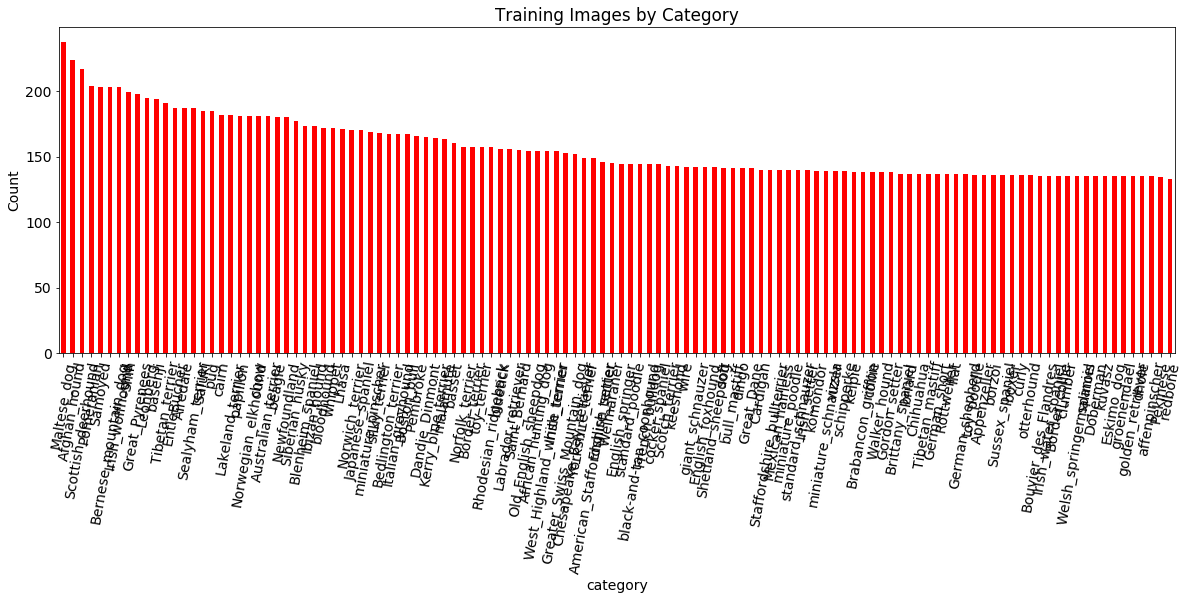

In [8]:
cat_df.set_index('category')['n_train'].plot.bar(
    color='r', figsize=(20, 6))
plt.xticks(rotation=80)
plt.ylabel('Count')
plt.title('Training Images by Category')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 50 Text xticklabel objects>)

Text(0,0.5,'Count')

Text(0.5,1,'Training Images by Category')

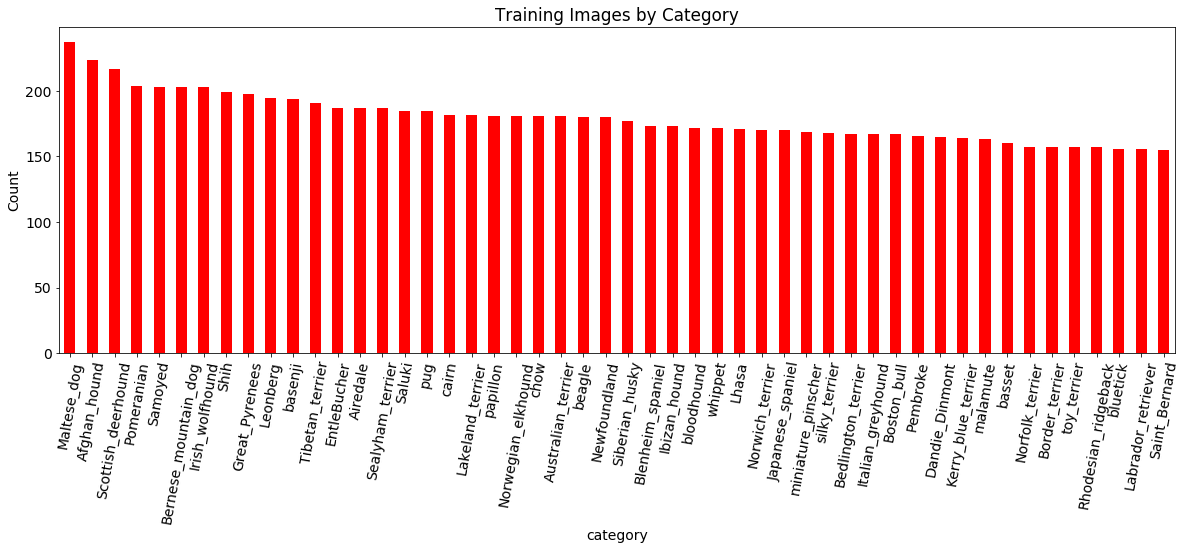

In [9]:
# Only top 50 categories
cat_df.set_index('category').iloc[:50]['n_train'].plot.bar(
    color='r', figsize=(20, 6))
plt.xticks(rotation=80)
plt.ylabel('Count')
plt.title('Training Images by Category')

### Distribution of Images Sizes
The images themselves have vastly different shapes. We can see this by looking at the stats of images sizes by category.

In [28]:
img_dsc = image_df.groupby('category').describe()
img_dsc.head()

height                                        \
                                count        mean         std    min    25%   
category                                                                      
Afghan_hound                    224.0  443.946429   80.325944  207.0  375.0   
African_hunting_dog             154.0  353.649351  122.115639  138.0  297.5   
Airedale                        187.0  397.705882   76.696330  180.0  349.5   
American_Staffordshire_terrier  149.0  380.456376   84.636702  164.0  333.0   
Appenzeller                     136.0  376.551471   79.632845  160.0  333.0   

                                                     width              \
                                  50%    75%    max  count        mean   
category                                                                 
Afghan_hound                    500.0  500.0  864.0  224.0  421.540179   
African_hunting_dog             333.0  375.0  960.0  154.0  466.766234   
Airedale                        375.0  500.0  500.0  187.0  444.085561   
American_Staffordshire_terrier  375.0  467.0  500.0  149.0  427.288591   
Appenzeller                     375.0  388.0  599.0  136.0  461.610294   

                                                                         \
                                       std    min     25%    50%    75%   
category                                                                  
Afghan_hound                     91.464214  193.0  343.75  411.0  500.0   
African_hunting_dog             178.658391  125.0  350.00  500.0  500.0   
Airedale                         79.438372  200.0  375.00  500.0  500.0   
American_Staffordshire_terrier   97.767809  166.0  350.00  500.0  500.0   
Appenzeller                      87.903244  187.0  409.50  500.0  500.0   

                                        
                                   max  
category                                
Afghan_hound                    1152.0  
African_hunting_dog             1280.0  
Airedale                         650.0  
American_Staffordshire_terrier   500.0  
Appenzeller                      679.0

Text(0.5,0,'Pixels')

Text(0,0.5,'Density')

Text(0.5,1,'Average Size Distribution')

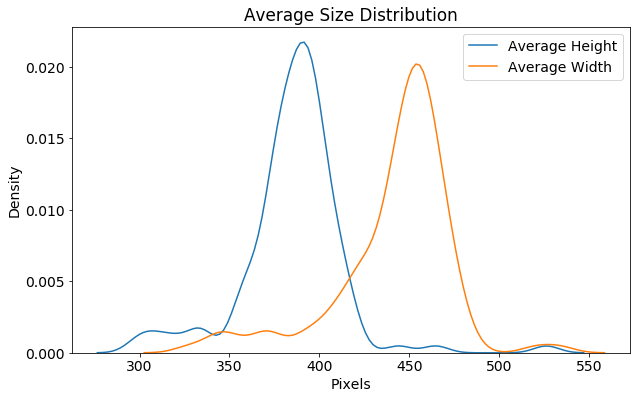

In [29]:
plt.figure(figsize=(10, 6))
sns.kdeplot(
    img_dsc['height']['mean'], label='Average Height')
sns.kdeplot(
    img_dsc['width']['mean'], label='Average Width')
plt.xlabel('Pixels')
plt.ylabel('Density')
plt.title('Average Size Distribution')

(375, 500, 3)

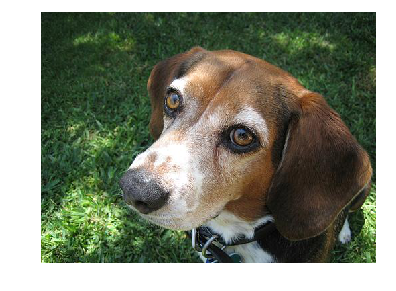

In [30]:
def imshow(image):
    """Display image"""
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Example image
x = Image.open(traindir + 'beagle/n02088364_2143.jpg')
np.array(x).shape
imshow(x)

(252, 300, 3)

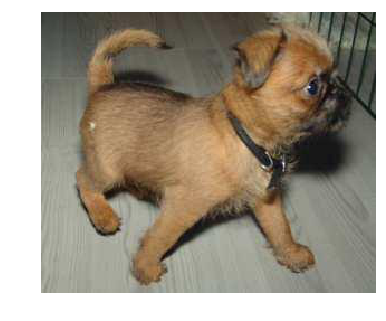

In [31]:
x = Image.open(traindir + 'Brabancon_griffon/n02112706_107.jpg')
np.array(x).shape
imshow(x)

### Image Preprocessing
To prepare the images for our network, we have to resize them to 224 x 224 and normalize each color channel by subtracting a mean value and dividing by a standard deviation. We will also augment our training data in this stage. These operations are done using image transforms, which prepare our data for a neural network.

### Data Augmentation
Because there are a limited number of images in some categories, we can use image augmentation to artificially increase the number of images "seen" by the network. This means for training, we randomly resize and crop the images and also flip them horizontally. A different random transformation is applied each epoch (while training), so the network effectively sees many different versions of the same image. All of the data is also converted to Torch Tensors before normalization. The validation and testing data is not augmented but is only resized and normalized. The normalization values are standardized for Imagenet.

In [32]:
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

### Examples of Augmentation
To show how augmentation works, we need to write a function that will plot a tensor as an image.

In [33]:
def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

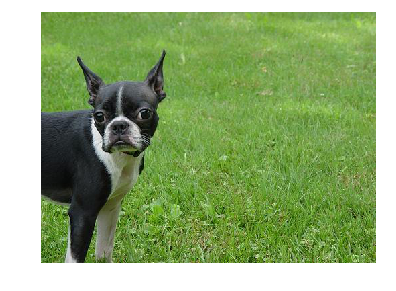

In [34]:
ex_img = Image.open(datadir + '/valid/Boston_bull/n02096585_12844.jpg')
imshow(ex_img)

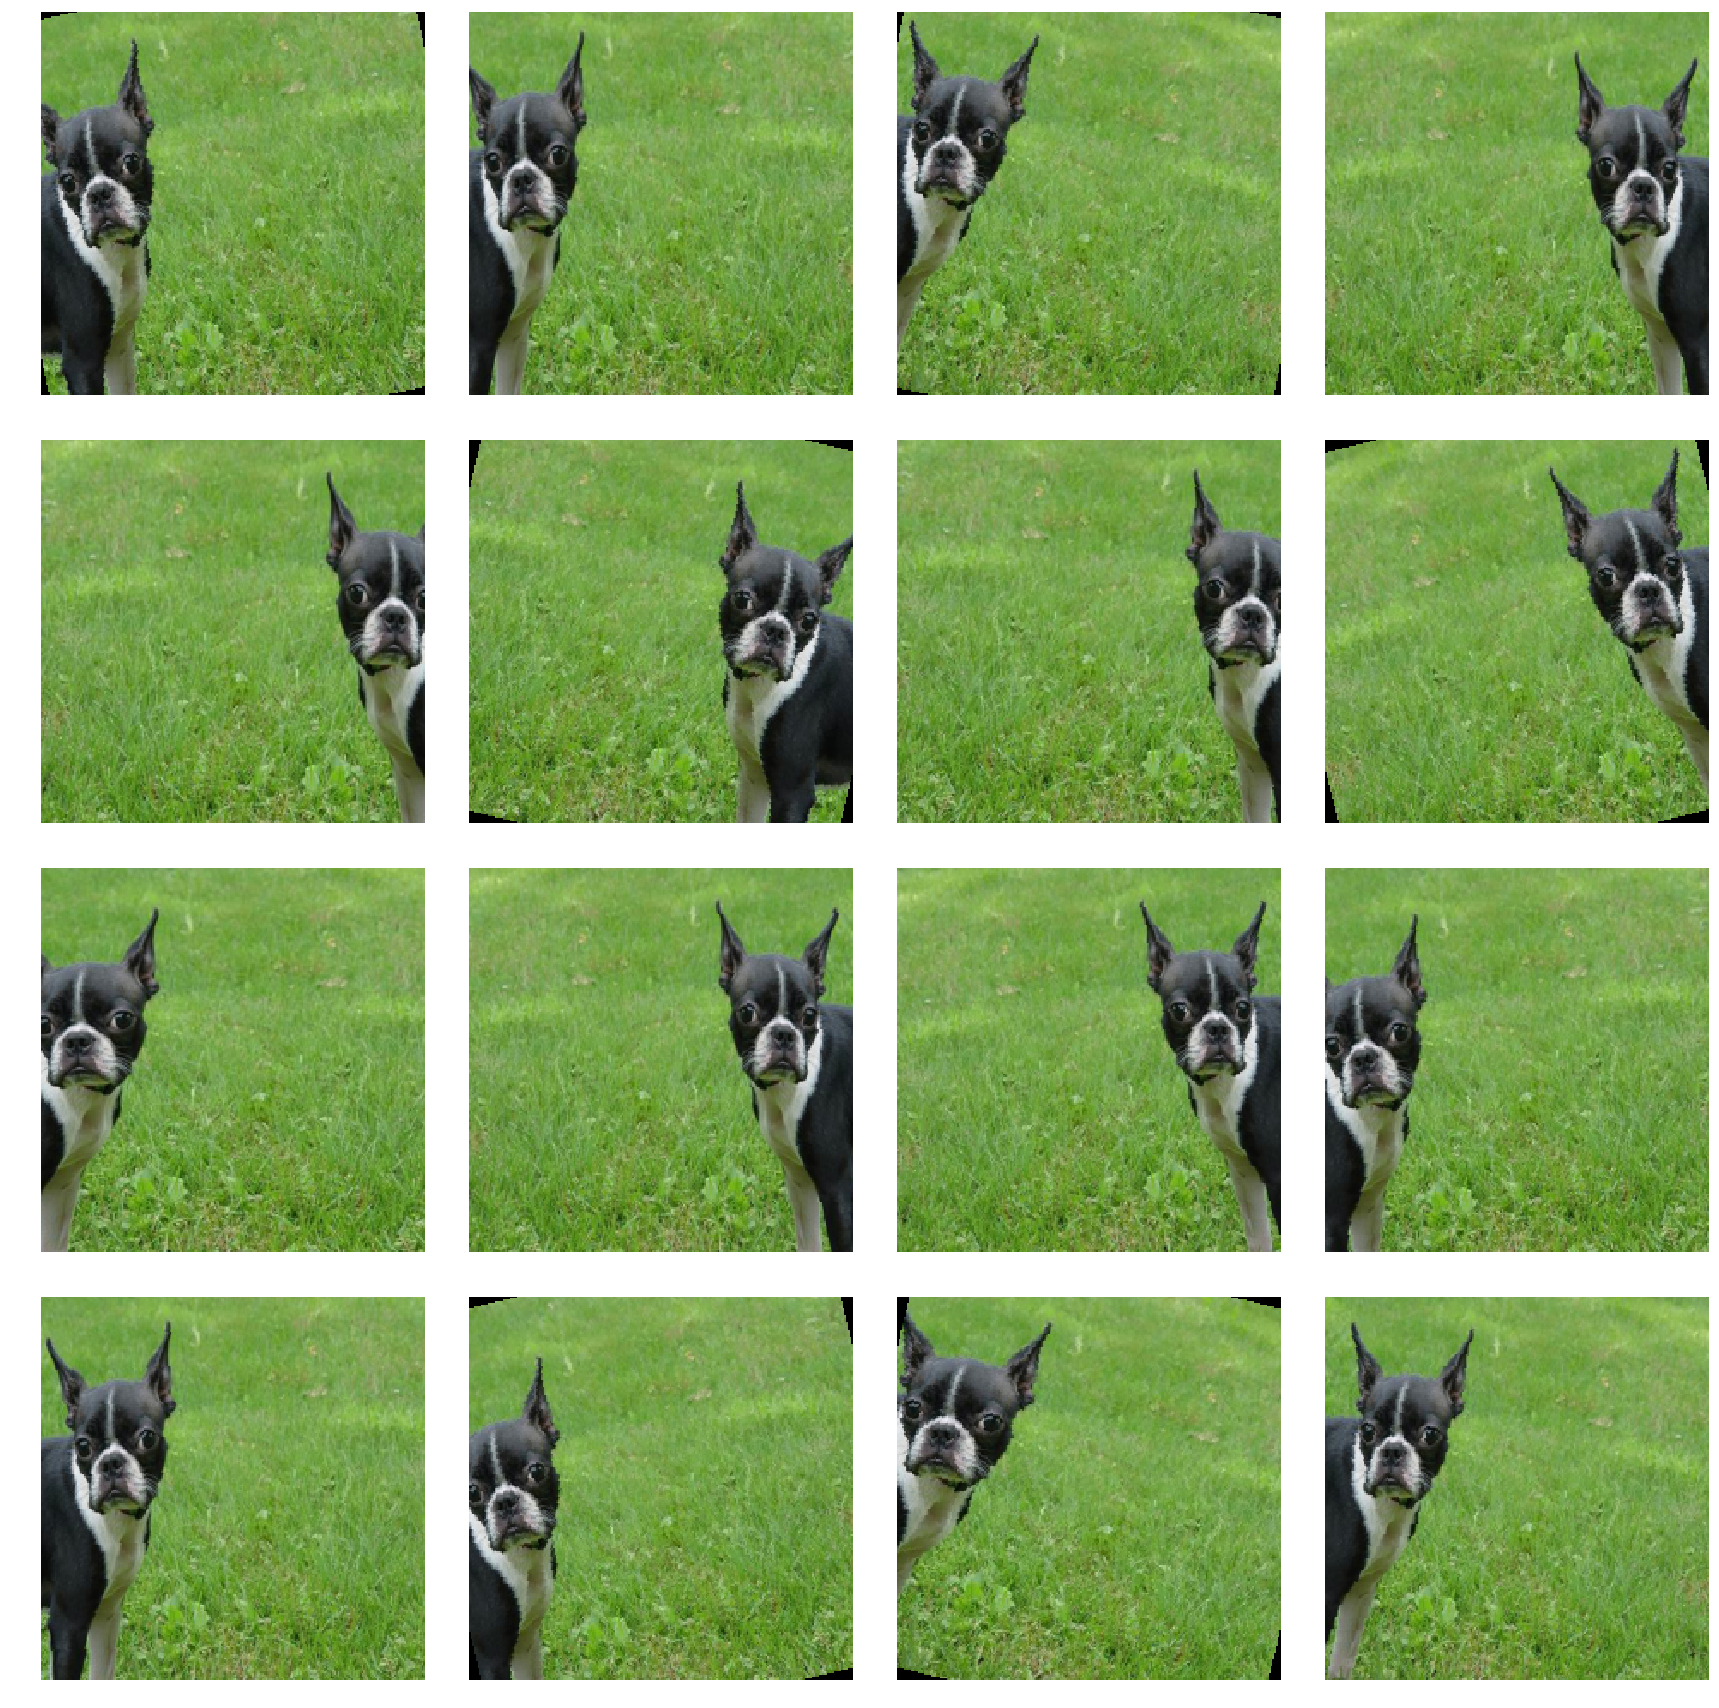

In [35]:
t = image_transforms['train']
plt.figure(figsize=(24, 24))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    _ = imshow_tensor(t(ex_img), ax=ax)

plt.tight_layout()

### Data Iterators
To avoid loading all of the data into memory at once, we use training DataLoaders. First, we create a dataset object from the image folders, and then we pass these to a DataLoader. At training time, the DataLoader will load the images from disk, apply the transformations, and yield a batch. To train and validation, we'll iterate through all the batches in the respective DataLoader.<br>
One crucial aspect is to shuffle the data before passing it to the network. This means that the ordering of the image categories changes on each pass through the data (one pass through the data is one training epoch).

In [36]:
# Datasets from each folder
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=validdir, transform=image_transforms['val']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}

# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

In [37]:
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

In [38]:
n_classes = len(cat_df)
print(f'There are {n_classes} different classes.')

len(data['train'].classes)

There are 120 different classes.


120

We can iterate through the DataLoaders when doing training, validation, and testing. This construction avoids the need to load all the data into memory and also will automatically apply the transformations to each batch. On each epoch, the Random transformations will be different so the network will essentially see multiple versions of each training image.

### Pre-Trained Models for Image Classification
PyTorch has many pretrained models we can use. All of these models have been trained on Imagenet which consists of millions of images across 1000 categories. What we want to do with pretrained models is freeze the early layers, and replace the classification module with our own.
### Approach
The approach for using a pre-trained image recognition model is well-established:
1. Load in pre-trained weights from a network trained on a large dataset
2. Freeze all the weights in the lower (convolutional) layers
Layers to freeze can be adjusted depending on similarity of task to large training dataset
3. Replace the classifier (fully connected) part of the network with a custom classifier
Number of outputs must be set equal to the number of classes
4. Train only the custom classifier (fully connected) layers for the task
Optimizer model classifier for smaller dataset

The idea behind pre-training is the early convolutional layers of a cnn extract features that are relevant for many image recognition tasks. The later, fully-connected layers, specialize to the specific dataset by learning higher-level features. Therefore, we can use the already trained convolutional layers while training only the fully-connected layers on our own dataset. Pre-trained networks have proven to be reasonably successful for a variety of tasks, and result in a significant reduction in training time and usually increases in performance.
The models available in PyTorch are listed below with the corresponding number of parameters.

In [39]:
model_options = pd.read_csv('/home/workspace/deep-learning-v2-pytorch/FINAL_PROJECT/models.csv')
model_options

model     params
0         AlexNet   61100840
1        DenseNet    7978856
2      Inception3   27161264
3      SqueezeNet    1248424
4         alexnet   61100840
5     densenet121    7978856
6     densenet161   28681000
7     densenet169   14149480
8     densenet201   20013928
9    inception_v3   27161264
10      resnet101   44549160
11      resnet152   60192808
12       resnet18   11689512
13       resnet34   21797672
14       resnet50   25557032
15  squeezenet1_0    1248424
16  squeezenet1_1    1235496
17          vgg11  132863336
18       vgg11_bn  132868840
19          vgg13  133047848
20       vgg13_bn  133053736
21          vgg16  138357544
22       vgg16_bn  138365992
23          vgg19  143667240
24       vgg19_bn  143678248

We'll be using the vgg16 although the code also has support for the resnet50. You can modify the code to use a different network quite easily. The VGG networks had very good performance without taking a long time to train.

### Process to Use Pre-Trained Model
We'll illustrate the process by using one model, vgg16.
First off, load in the model with pretrained weights.

In [26]:
model = models.vgg16(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:12<00:00, 44687929.44it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

The classifier is the part of the model that we'll train. However, for the vgg, we'll only need to train the last few layers in the classifier and not even all of the fully connected layers.

In [28]:
# Freeze early layers
for param in model.parameters():
    param.requires_grad = False

### Add on Custom Classifier
We'll train a classifier consisting of the following layers
Fully connected with ReLU activation (n_inputs, 256)
Dropout with 40% chance of dropping
Fully connected with log softmax output (256, n_classes)
To build our custom classifier, we use the nn.Sequential() module which allows us to specify each layer one after the other. We assign our custom classifier to the final classifier layer in the already trained vgg network. When we add on the extra layers, they are set to require_grad=True by default. These will be the only layers that are trained.

In [29]:
n_inputs = model.classifier[6].in_features

# Add on classifier
model.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.4),
    nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4)
    (3): Linear(in_features=256, out_features=120, bias=True)
    (4): LogSoftmax()
  )
)

In [30]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

135,340,216 total parameters.
1,079,672 training parameters.


Even with only a few layers set to trainable, there are still over a million parameters (weights) that will be updated during training. In effect, we are fine-tuning the model to work on our problem. We already know it works well on Imagenet, and because our images are relatively similar, we should expect the model to easily transfer its knowledge from Imagenet to our dataset.
### Move to GPU
To use a gpu in PyTorch, we simply move the whole model onto the gpu. Later we'll have to move the data to gpus in our training loop.
Since I am using multiple gpus, I also distribute the model across both of them with nn.DataParallel.

In [31]:
#multi_gpu = False
if train_on_gpu:
    model = model.to('cuda')

if multi_gpu:
    model = nn.DataParallel(model)

In [ ]:
def get_pretrained_model(model_name):
    """Retrieve a pre-trained model from torchvision

    Params
    -------
        model_name (str): name of the model (currently only accepts vgg16 and resnet50)

    Return
    --------
        model (PyTorch model): cnn

    """

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)

        # Freeze early layers
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features

        # Add on classifier
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False

        n_inputs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    # Move to gpu and parallelize
    if train_on_gpu:
        model = model.to('cuda')

    if multi_gpu:
        model = nn.DataParallel(model)

    return model

In [33]:
model = get_pretrained_model('vgg16')
if multi_gpu:
    summary(
        model.module,
        input_size=(3, 224, 224),
        batch_size=batch_size,
        device='cuda')
else:
    summary(
        model, input_size=(3, 224, 224), batch_size=batch_size, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 224, 224]           1,792
              ReLU-2        [128, 64, 224, 224]               0
            Conv2d-3        [128, 64, 224, 224]          36,928
              ReLU-4        [128, 64, 224, 224]               0
         MaxPool2d-5        [128, 64, 112, 112]               0
            Conv2d-6       [128, 128, 112, 112]          73,856
              ReLU-7       [128, 128, 112, 112]               0
            Conv2d-8       [128, 128, 112, 112]         147,584
              ReLU-9       [128, 128, 112, 112]               0
        MaxPool2d-10         [128, 128, 56, 56]               0
           Conv2d-11         [128, 256, 56, 56]         295,168
             ReLU-12         [128, 256, 56, 56]               0
           Conv2d-13         [128, 256, 56, 56]         590,080
             ReLU-14         [128, 256,

We can see that the model is quite large and training all of the layers would take a considerable time. Even with only a few layers to train, this can still take a while to train. You might need to decrease the batch_size if this is not fitting on your gpu (hopefully you have one).

In [34]:
if multi_gpu:
    print(model.module.classifier[6])
else:
    print(model.classifier[6])

Sequential(
  (0): Linear(in_features=4096, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2)
  (3): Linear(in_features=256, out_features=120, bias=True)
  (4): LogSoftmax()
)


### Mapping of Classes to Indexes
To keep track of the predictions made by the model, we create a mapping of classes to indexes and indexes to classes. This will let us know the actual class for a given prediction.

In [35]:
model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())[:10]

[(0, 'Afghan_hound'),
 (1, 'African_hunting_dog'),
 (2, 'Airedale'),
 (3, 'American_Staffordshire_terrier'),
 (4, 'Appenzeller'),
 (5, 'Australian_terrier'),
 (6, 'Bedlington_terrier'),
 (7, 'Bernese_mountain_dog'),
 (8, 'Blenheim_spaniel'),
 (9, 'Border_collie')]

### Training Loss and Optimizer
The loss is the negative log likelihood and the optimizer is the Adam optimizer. The negative log likelihood in PyTorch expects log probabilities so we need to pass it the raw output from the log softmax in our model's final layer. The optimizer is told to optimizer the model parameters (only a few of which require a gradient).
* Loss (criterion): keeps track of the loss itself and the gradients of the loss with respect to the model parameters (weights)
* Optimizer: updates the parameters (weights) with the gradients

In [17]:
model.parameters()

<generator object Module.parameters at 0x7fb87c258bf8>

In [18]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad,model.parameters()))

Below we can look at the parameters (weights) that will be updated by the optimizer during training.


In [19]:
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([256, 4096])
torch.Size([256])
torch.Size([120, 256])
torch.Size([120])


## Training
For training, we iterate through the train DataLoader, each time passing one batch through the model. One complete pass through the training data is known as an epoch, and we train for a set number of epochs or until early stopping kicks in (more below). After each batch, we calculate the loss (with criterion(output, targets)) and then calculate the gradients of the loss with respect to the model parameters with loss.backward(). This uses autodifferentiation and backpropagation to calculate the gradients.
After calculating the gradients, we call optimizer.step() to update the model parameters with the gradients. This is done on every training batch so we are implementing stochastic gradient descent (or rather a version of it with momentum known as Adam). For each batch, we also compute the accuracy for monitoring and after the training loop has completed, we start the validation loop. This will be used to carry out early stopping.
### Early Stopping
Early stopping halts the training when the validation loss has not decreased for a number of epochs. Each time the validation loss does decrease, the model weights are saved so we can later load in the best model. Early stopping is an effective method to prevent overfitting on the training data. If we continue training, the training loss will continue to decrease, but the validation loss will increase because the model is starting to memorize the training data. Early stopping prevents this from happening, and, if we save the model each epoch when the validation loss decreases, we are able to retrieve the model that does best on the validation data.
Early stopping is implemented by iterating through the validation data at the end of each training epoch and calculating the loss. We use the complete validation data every time and record whether or not the loss has decreased. If it has not for a number of epochs, we stop training, retrieve the best weights, and return them. When in the validation loop, we make sure not to update the model parameters.
### Training Function
The below function trains the network while monitoring a number of different parameters. We train with early stopping on the validation set. There are a number of parameters that I've tried to explain in the doc string. Hopefully, the comments and background make things somewhat understandable!

In [15]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [41]:
model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=20,
    print_every=2)

Model has been trained for: 1 epochs.

Epoch: 1	100.00% complete. 330.04 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.7796 	Validation Loss: 0.5305
		Training Accuracy: 75.62%	 Validation Accuracy: 82.28%
Epoch: 3	100.00% complete. 329.13 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.7157 	Validation Loss: 0.4873
		Training Accuracy: 77.12%	 Validation Accuracy: 83.89%
Epoch: 5	100.00% complete. 329.30 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.6743 	Validation Loss: 0.4882
		Training Accuracy: 78.14%	 Validation Accuracy: 84.44%
Epoch: 7	100.00% complete. 329.21 seconds elapsed in epoch.
Epoch: 7 	Training Loss: 0.6412 	Validation Loss: 0.4927
		Training Accuracy: 79.39%	 Validation Accuracy: 83.61%

Early Stopping! Total epochs: 7. Best epoch: 2 with loss: 0.48 and acc: 83.61%
2893.02 total seconds elapsed. 361.63 seconds per epoch.


## Training Results
We can inspect the training progress by looking at the history.

Text(0.5,0,'Epoch')

Text(0,0.5,'Average Negative Log Likelihood')

Text(0.5,1,'Training and Validation Losses')

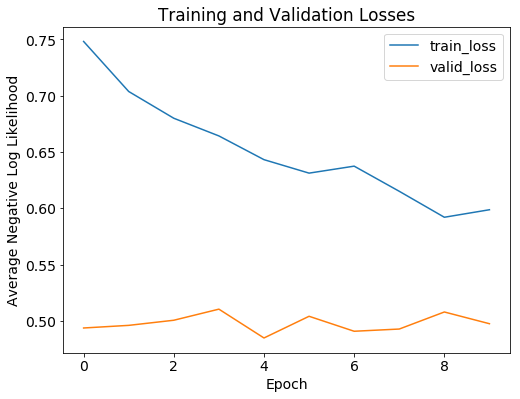

In [69]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

Text(0.5,0,'Epoch')

Text(0,0.5,'Average Accuracy')

Text(0.5,1,'Training and Validation Accuracy')

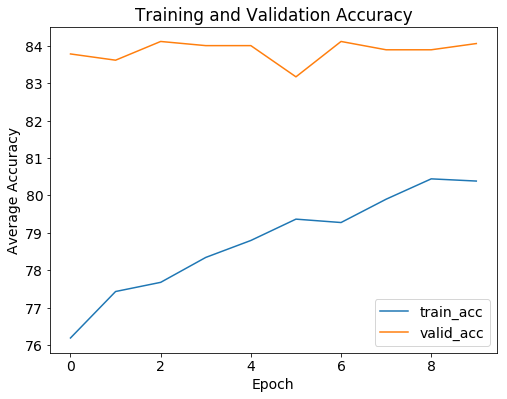

In [70]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

### Saving Model
The train function saves the best model state_dict() which are the weights of the model. To save more information about the model, we use the below function.

In [11]:
def save_checkpoint(model, path):
    """Save a PyTorch model checkpoint

    Params
    --------
        model (PyTorch model): model to save
        path (str): location to save model. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    model_name = path.split('-')[0]
    assert (model_name in ['vgg16', 'resnet50'
                           ]), "Path must have the correct model name"

    # Basic details
    checkpoint = {
        'class_to_idx': model.class_to_idx,
        'idx_to_class': model.idx_to_class,
        'epochs': model.epochs,
    }

    # Extract the final classifier and the state dictionary
    if model_name == 'vgg16':
        # Check to see if model was parallelized
        if multi_gpu:
            checkpoint['classifier'] = model.module.classifier
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['classifier'] = model.classifier
            checkpoint['state_dict'] = model.state_dict()

    elif model_name == 'resnet50':
        if multi_gpu:
            checkpoint['fc'] = model.module.fc
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['fc'] = model.fc
            checkpoint['state_dict'] = model.state_dict()

    # Add the optimizer
    checkpoint['optimizer'] = model.optimizer
    checkpoint['optimizer_state_dict'] = model.optimizer.state_dict()

    # Save the data to the path
    torch.save(checkpoint, path)

In [45]:
save_checkpoint(model, path=checkpoint_path)

### Load in a Checkpoint
Now we need to write the function to load in the checkpoint. This just takes in a path and returns a model from a saved checkpoint.

In [12]:
def load_checkpoint(path):
    """Load a PyTorch model checkpoint

    Params
    --------
        path (str): saved model checkpoint. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    # Get the model name
    model_name = path.split('-')[0]
    assert (model_name in ['vgg16', 'resnet50'
                           ]), "Path must have the correct model name"

    # Load in checkpoint
    checkpoint = torch.load(path)

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.classifier = checkpoint['classifier']

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.fc = checkpoint['fc']

    # Load in the state dict
    model.load_state_dict(checkpoint['state_dict'])

    total_params = sum(p.numel() for p in model.parameters())
    print(f'{total_params:,} total parameters.')
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f'{total_trainable_params:,} total gradient parameters.')

    # Move to gpu
    if multi_gpu:
        model = nn.DataParallel(model)

    if train_on_gpu:
        model = model.to('cuda')

    # Model basics
    model.class_to_idx = checkpoint['class_to_idx']
    model.idx_to_class = checkpoint['idx_to_class']
    model.epochs = checkpoint['epochs']

    # Optimizer
    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optimizer

In [13]:
model, optimizer = load_checkpoint(path=checkpoint_path)

if multi_gpu:
    summary(model.module, input_size=(3, 224, 224), batch_size=batch_size)
else:
    summary(model, input_size=(3, 224, 224), batch_size=batch_size)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 98575088.51it/s] 


135,340,216 total parameters.
1,079,672 total gradient parameters.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 224, 224]           1,792
              ReLU-2        [128, 64, 224, 224]               0
            Conv2d-3        [128, 64, 224, 224]          36,928
              ReLU-4        [128, 64, 224, 224]               0
         MaxPool2d-5        [128, 64, 112, 112]               0
            Conv2d-6       [128, 128, 112, 112]          73,856
              ReLU-7       [128, 128, 112, 112]               0
            Conv2d-8       [128, 128, 112, 112]         147,584
              ReLU-9       [128, 128, 112, 112]               0
        MaxPool2d-10         [128, 128, 56, 56]               0
           Conv2d-11         [128, 256, 56, 56]         295,168
             ReLU-12         [128, 256, 56, 56]               0
           Conv2d-13         [128, 2

We can now use these two functions to save and load in a complete model. We can use this model to continue training.

In [71]:
model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=10,
    n_epochs=30,
    print_every=1)


Model has been trained for: 19 epochs.

Epoch: 1	100.00% complete. 322.71 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.6159 	Validation Loss: 0.5097
		Training Accuracy: 79.74%	 Validation Accuracy: 83.56%
Epoch: 3	100.00% complete. 322.83 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.6011 	Validation Loss: 0.5048
		Training Accuracy: 80.11%	 Validation Accuracy: 84.33%
Epoch: 5	100.00% complete. 321.75 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.5832 	Validation Loss: 0.4926
		Training Accuracy: 80.68%	 Validation Accuracy: 84.56%
Epoch: 7	100.00% complete. 322.04 seconds elapsed in epoch.
Epoch: 7 	Training Loss: 0.5901 	Validation Loss: 0.5203
		Training Accuracy: 80.56%	 Validation Accuracy: 83.89%
Epoch: 9	100.00% complete. 321.73 seconds elapsed in epoch.
Epoch: 9 	Training Loss: 0.5707 	Validation Loss: 0.5059
		Training Accuracy: 81.16%	 Validation Accuracy: 84.39%
Epoch: 11	100.00% complete. 322.89 seconds elapsed in epoch.
Epoch: 11 	Training Loss: 0.5

### Inference
After the model has been trained to the point on no more improvement on the validation data, we need to test it on data it has never seen. Early stopping with a validation set does decrease overfitting to the training set, but at the cost of potentially overfitting to the validation data. For a final estimate of the model's performance, we need to use the hold out testing data. Here, we'll look at individual predictions along with loss and accuracy on the entire testing dataset.
This function processes an image path into a PyTorch tensor for predictions. It applies the same transformations as was done to the validation data: cropping (center) and normalizing with means and standard deviations.

In [72]:
def process_image(image_path):
    """Process an image path into a PyTorch tensor"""

    image = Image.open(image_path)
    # Resize
    img = image.resize((256, 256))

    # Center crop
    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))

    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 256

    # Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor

In [73]:
x = process_image(testdir + 'cocker_spaniel/n02102318_4217.jpg')
x.shape

torch.Size([3, 224, 224])

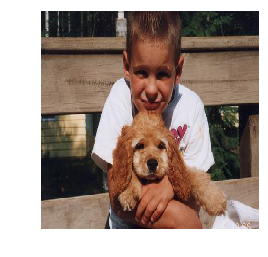

In [74]:
ax, image = imshow_tensor(x)


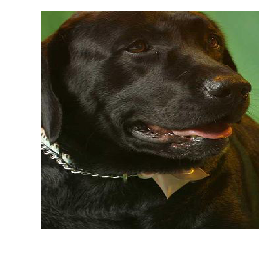

In [75]:
ax, image = imshow_tensor(process_image(testdir + 'Labrador_retriever/n02099712_7493.jpg'))

### Function to make predictions
The next function makes predictions on a single image. It will return the top probabilities and classes.

In [76]:
def predict(image_path, model, topk=5):
    """Make a prediction for an image using a trained model

    Params
    --------
        image_path (str): filename of the image
        model (PyTorch model): trained model for inference
        topk (int): number of top predictions to return

    Returns

    """
    real_class = image_path.split('/')[-2]

    # Convert to pytorch tensor
    img_tensor = process_image(image_path)

    # Resize
    if train_on_gpu:
        img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
    else:
        img_tensor = img_tensor.view(1, 3, 224, 224)

    # Set to evaluation
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(img_tensor)
        ps = torch.exp(out)

        # Find the topk predictions
        topk, topclass = ps.topk(topk, dim=1)

        # Extract the actual classes and probabilities
        top_classes = [
            model.idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]
        ]
        top_p = topk.cpu().numpy()[0]

        return img_tensor.cpu().squeeze(), top_p, top_classes, real_class

In [77]:
np.random.seed = 100


def random_test_image():
    """Pick a random test image from the test directory"""
    c = np.random.choice(cat_df['category'])
    root = testdir + c + '/'
    img_path = root + np.random.choice(os.listdir(root))
    return img_path

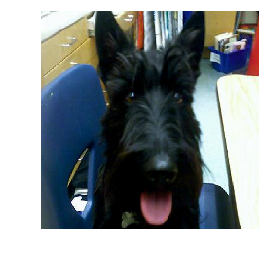

In [78]:
_ = imshow_tensor(process_image(random_test_image()))

In [79]:
img, top_p, top_classes, real_class = predict(random_test_image(), model)
img.shape

torch.Size([3, 224, 224])

In [80]:
top_p, top_classes, real_class


(array([ 0.58220947,  0.22088252,  0.19195779,  0.0014705 ,  0.001377  ], dtype=float32),
 ['Greater_Swiss_Mountain_dog',
  'EntleBucher',
  'Appenzeller',
  'basenji',
  'American_Staffordshire_terrier'],
 'Greater_Swiss_Mountain_dog')

In [81]:
img, top_p, top_classes, real_class = predict(random_test_image(), model)
top_p, top_classes, real_class

(array([ 0.85015601,  0.09961498,  0.03771836,  0.01057298,  0.00111579], dtype=float32),
 ['English_springer',
  'cocker_spaniel',
  'English_setter',
  'clumber',
  'Brittany_spaniel'],
 'clumber')

### Function to Display Predictions
This function displays the picture along with the topk predictions from the model. The title over the image displays the true class.

In [82]:
def display_prediction(image_path, model, topk):
    """Display image and preditions from model"""

    # Get predictions
    img, ps, classes, y_obs = predict(image_path, model, topk)
    # Convert results to dataframe for plotting
    result = pd.DataFrame({'p': ps}, index=classes)

    # Show the image
    plt.figure(figsize=(16, 5))
    ax = plt.subplot(1, 2, 1)
    ax, img = imshow_tensor(img, ax=ax)

    # Set title to be the actual class
    ax.set_title(y_obs, size=20)

    ax = plt.subplot(1, 2, 2)
    # Plot a bar plot of predictions
    result.sort_values('p')['p'].plot.barh(color='blue', edgecolor='k', ax=ax)
    plt.xlabel('Predicted Probability')
    plt.tight_layout()

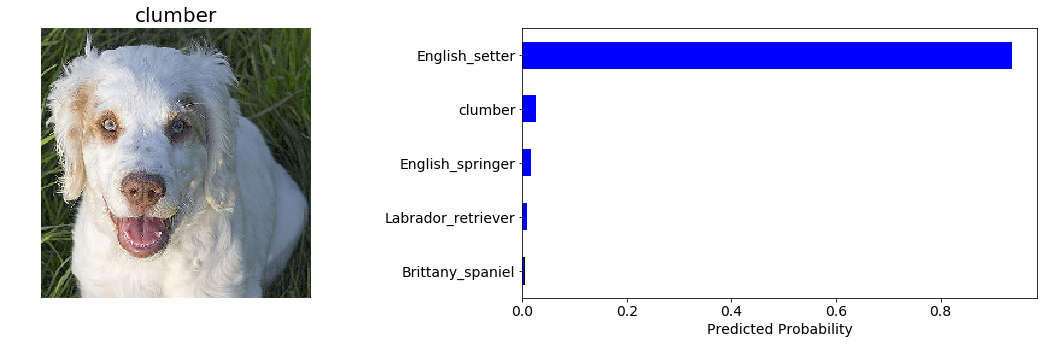

In [83]:
display_prediction(random_test_image(), model, topk=5)

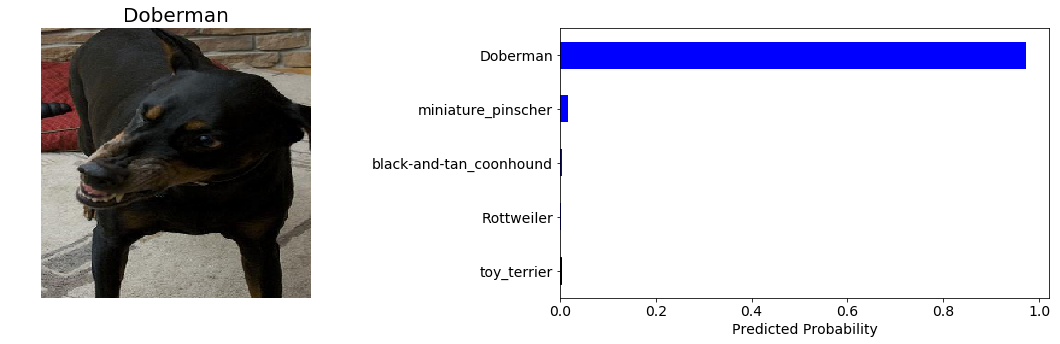

In [84]:
display_prediction(random_test_image(), model, topk=5)


### Testing Accuracy
Image identification models are usually assessed in terms of topk accuracy (for example the vgg16 model gets 28.41% top1 error and 9.62% top5 error on Imagenet). We'll assess out model by the top1 and top5 accuracy, that is, the percentage of predictions it gets exactly correct, and the percentage of predictions where the real class is in the top 5 actual classes.
The function below computes accuracy for a prediction and a target in terms of topk.

In [85]:
def accuracy(output, target, topk=(1, )):
    """Compute the topk accuracy(s)"""
    if train_on_gpu:
        output = output.to('cuda')
        target = target.to('cuda')

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # Find the predicted classes and transpose
        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True)
        pred = pred.t()

        # Determine predictions equal to the targets
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []

        # For each k, find the percentage of correct
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res

In [86]:
testiter = iter(dataloaders['test'])
# Get a batch of testing images and labels
features, targets = next(testiter)

if train_on_gpu:
    accuracy(model(features.to('cuda')), targets, topk=(1, 5))
else:
    accuracy(model(features), targets, topk=(1, 5))

[84.375, 97.65625]

### Function to Evaluate Model Over All Classes
The next function iterates through the testing set in order to make predictions for each image. It calculates performance for each category.

In [56]:
def evaluate(model, test_loader, criterion, topk=(1, 5)):
    """Measure the performance of a trained PyTorch model

    Params
    --------
        model (PyTorch model): trained cnn for inference
        test_loader (PyTorch DataLoader): test dataloader
        topk (tuple of ints): accuracy to measure

    Returns
    --------
        results (DataFrame): results for each category

    """

    classes = []
    losses = []
    # Hold accuracy results
    acc_results = np.zeros((len(test_loader.dataset), len(topk)))
    i = 0

    model.eval()
    with torch.no_grad():

        # Testing loop
        for data, targets in test_loader:

            # Tensors to gpu
            if train_on_gpu:
                data, targets = data.to('cuda'), targets.to('cuda')

            # Raw model output
            out = model(data)
            # Iterate through each example
            for pred, true in zip(out, targets):
                # Find topk accuracy
                acc_results[i, :] = accuracy(
                    pred.unsqueeze(0), true.unsqueeze(0), topk)
                classes.append(model.idx_to_class[true.item()])
                # Calculate the loss
                loss = criterion(pred.view(1, n_classes), true.view(1))
                losses.append(loss.item())
                i += 1

    # Send results to a dataframe and calculate average across classes
    results = pd.DataFrame(acc_results, columns=[f'top{i}' for i in topk])
    results['class'] = classes
    results['loss'] = losses
    results = results.groupby(classes).mean()

    return results.reset_index().rename(columns={'index': 'class'})

In [87]:
criterion = nn.NLLLoss()
# Evaluate the model on all the training data
results = evaluate(model, dataloaders['test'], criterion)
results.head()

class   top1   top5      loss
0                    Afghan_hound  100.0  100.0  0.009308
1             African_hunting_dog   80.0  100.0  0.304809
2                        Airedale   80.0  100.0  0.376620
3  American_Staffordshire_terrier  100.0  100.0  0.200225
4                     Appenzeller   20.0  100.0  1.440187

### Test Results
We'd expect the model to do better on those classes for which it had the most training images. We can see if that is the case.

Text(0.5,11.12,'images')

Text(6.87,0.5,'Accuracy (%)')

Text(0.5,1,'Top 1 Accuracy vs Number of Training Images')

(-5, 105)

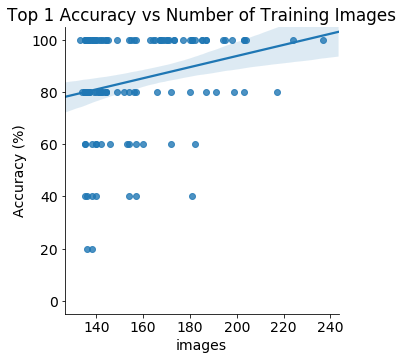

In [88]:
results = results.merge(cat_df, left_on='class', right_on='category').\
    drop(columns=['category'])

# Plot using seaborn
sns.lmplot( y='top1', x='n_train', data=results)
plt.xlabel('images')
plt.ylabel('Accuracy (%)')
plt.title('Top 1 Accuracy vs Number of Training Images')
plt.ylim(-5, 105)

In [89]:
results.head()

class   top1   top5      loss  n_train  n_valid  \
0                    Afghan_hound  100.0  100.0  0.009308      224       15   
1             African_hunting_dog   80.0  100.0  0.304809      154       15   
2                        Airedale   80.0  100.0  0.376620      187       15   
3  American_Staffordshire_terrier  100.0  100.0  0.200225      149       15   
4                     Appenzeller   20.0  100.0  1.440187      136       15   

   n_test  
0       5  
1       5  
2       5  
3       5  
4       5

In [90]:
print('Category with minimum accuracy.')
results.loc[results['top1'].idxmin]

print('Category with minimum images.')
results.loc[results['n_train'].idxmin]


Category with minimum accuracy.


class      Appenzeller
top1                20
top5               100
loss           1.44019
n_train            136
n_valid             15
n_test               5
Name: 4, dtype: object

Category with minimum images.


class       redbone
top1            100
top5            100
loss       0.183903
n_train         133
n_valid          15
n_test            5
Name: 109, dtype: object

Text(0.5,11.12,'images')

Text(6.87,0.5,'Accuracy (%)')

Text(0.5,1,'Top 5 Accuracy vs Number of Training Images')

(-5, 105)

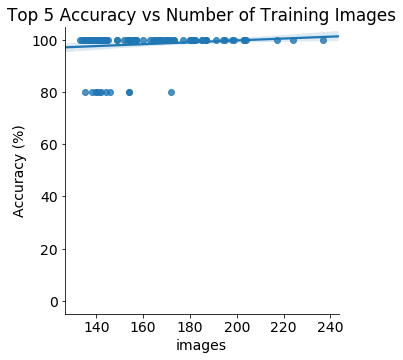

In [91]:
sns.lmplot(
    y='top5', x='n_train', data=results)
plt.xlabel('images')
plt.ylabel('Accuracy (%)')
plt.title('Top 5 Accuracy vs Number of Training Images')
plt.ylim(-5, 105)

It looks like there is some relationship between the number of training images and the accuracy. However, there are a few classes with limited images in which the model does quite well.

In [62]:
# Weighted column of test images
results['weighted'] = results['n_test'] / results['n_test'].sum()

# Create weighted accuracies
for i in (1, 5):
    results[f'weighted_top{i}'] = results['weighted'] * results[f'top{i}']

# Find final accuracy accounting for frequencies
top1_weighted = results['weighted_top1'].sum()
top5_weighted = results['weighted_top5'].sum()
loss_weighted = (results['weighted'] * results['loss']).sum()

print(f'Final test cross entropy per image = {loss_weighted:.4f}.')
print(f'Final test top 1 weighted accuracy = {top1_weighted:.2f}%')
print(f'Final test top 5 weighted accuracy = {top5_weighted:.2f}%')

Final test cross entropy per image = 0.4663.
Final test top 1 weighted accuracy = 85.00%
Final test top 5 weighted accuracy = 98.33%


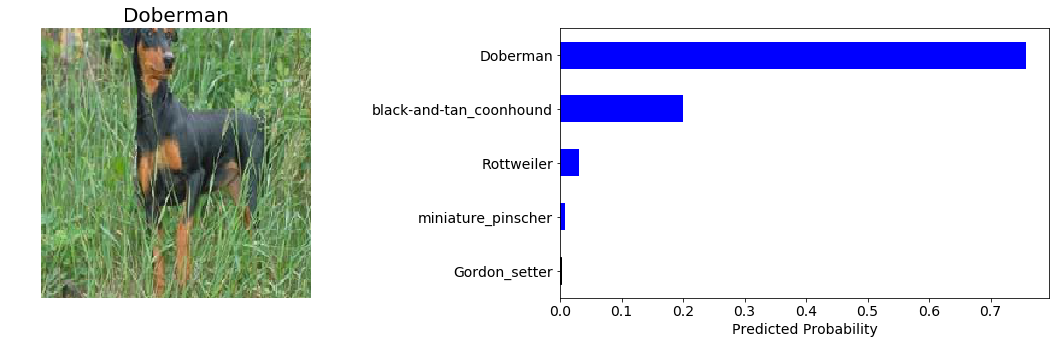

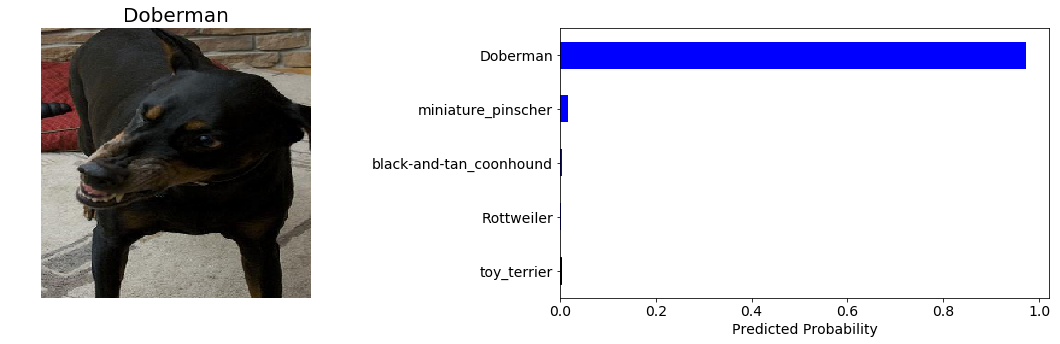

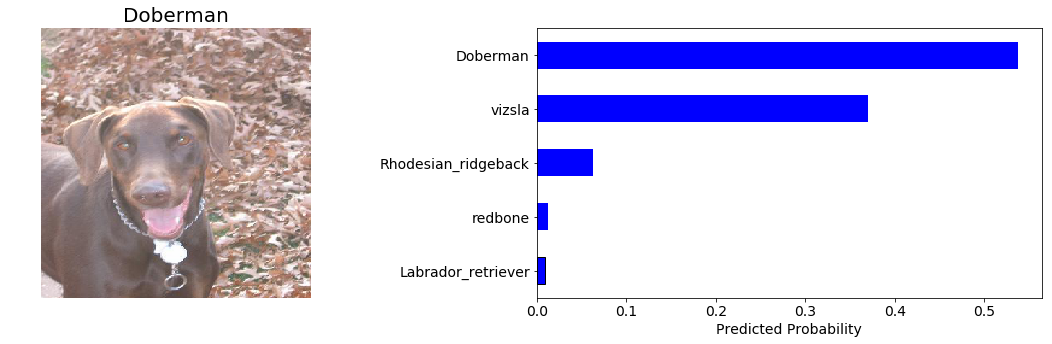

In [92]:
test_doberman = '/home/workspace/deep-learning-v2-pytorch/FINAL_PROJECT/train_test_valid/test/Doberman/'
croc1 = test_doberman + 'n02107142_18020.jpg'
croc2 = test_doberman + 'n02107142_10036.jpg'
croc3 = test_doberman + 'n02107142_3741.jpg'

display_prediction(croc1, model, 5)
display_prediction(croc2, model, 5)
display_prediction(croc3, model, 5)

Given the subtle distinction between crocodile and crocodile_head, I'd say that this model does pretty well! The ultimate bar in image recognition is human level, and our model is nearly there.

In [93]:
def display_category(model, category, n=4):
    """Display predictions for a category    
    """
    category_results = results.loc[results['class'] == category]
    print(category_results.iloc[:, :6], '/n')

    images = np.random.choice(
        os.listdir(testdir + category + '/'), size=4, replace=False)

    for img in images:
        display_prediction(testdir + category + '/' + img, model, 5)

     class  top1   top5      loss  n_train  n_valid
77  beagle  80.0  100.0  0.585595      180       15 /n


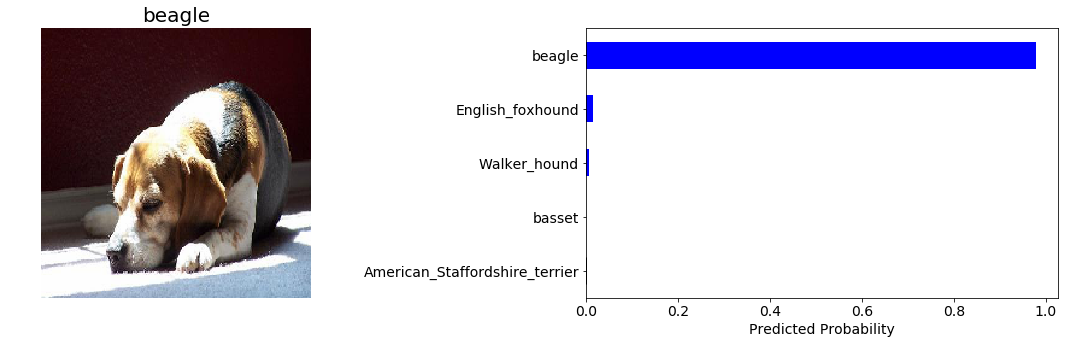

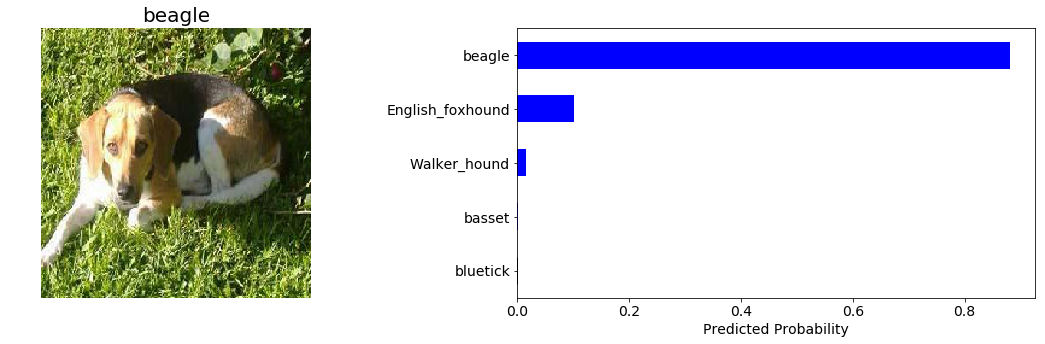

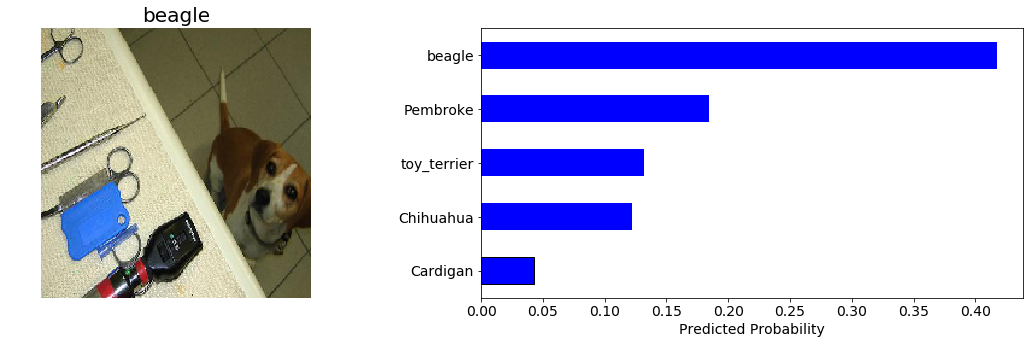

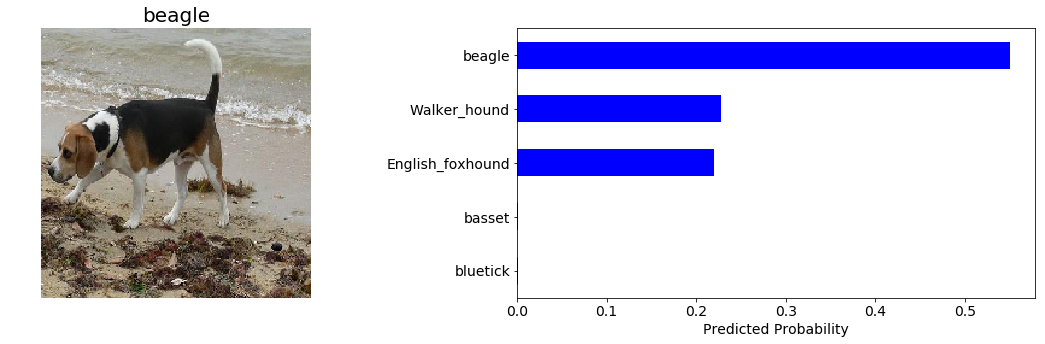

In [95]:
display_category(model, 'beagle')


In [ ]:
display_category(model, 'Eskimo_dog')


In [ ]:
display_category(model, 'Labrador_retriever')


               class  top1   top5      loss  n_train  n_valid
95  golden_retriever  80.0  100.0  0.475482      135       15 /n


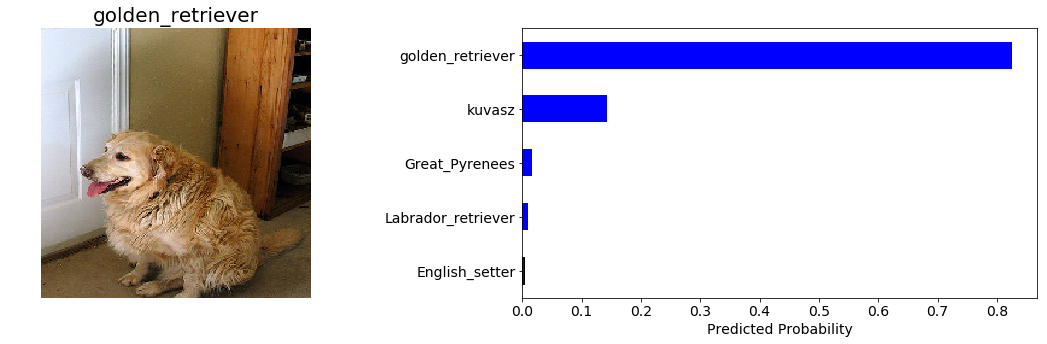

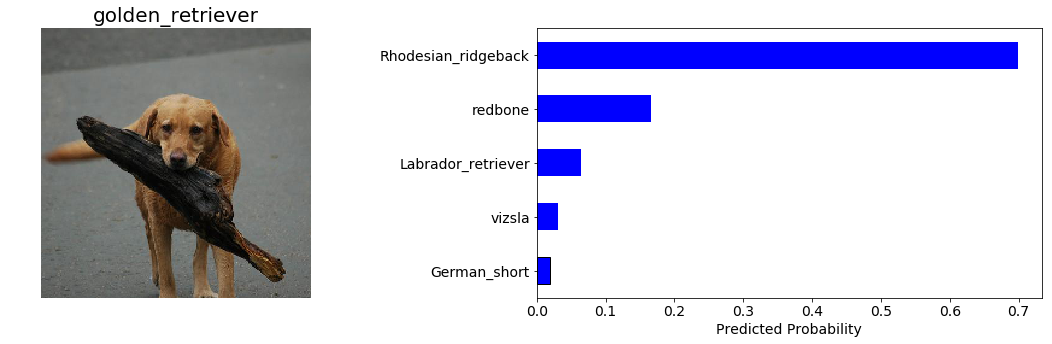

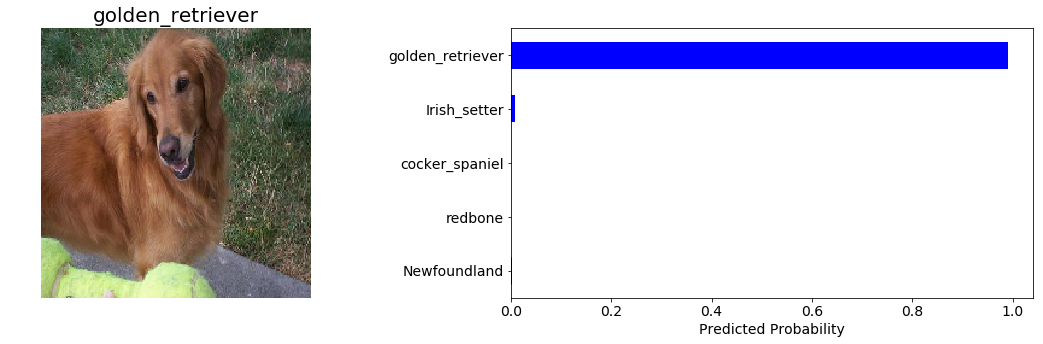

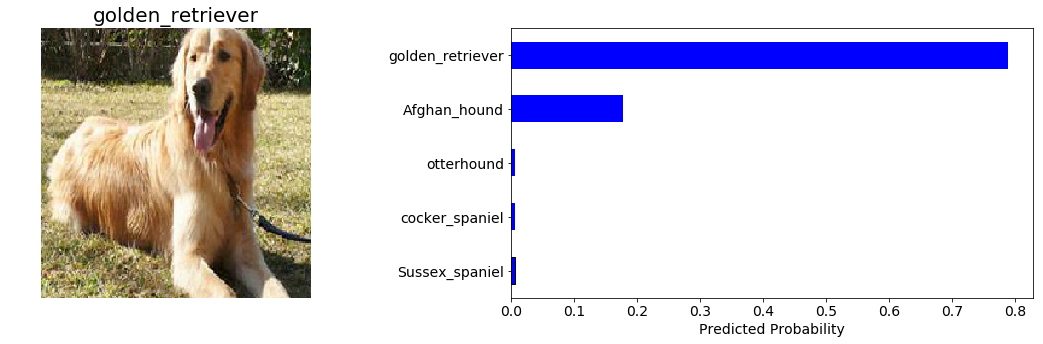

In [68]:
display_category(model, 'golden_retriever')


### Doing predictions using a specific folder


In [98]:
data_dir = '/home/workspace/deep-learning-v2-pytorch/FINAL_PROJECT/train_test_valid/test'
"""
test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                     ])
"""
test_transforms = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])   ])

'\ntest_transforms = transforms.Compose([transforms.Resize(224),\n                                      transforms.ToTensor(),\n                                     ])\n'

In [105]:
from torch.autograd import Variable

In [106]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [115]:
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

In [113]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [118]:
classes = data.get('classes')

In [119]:
classes

NameError: name 'classes' is not defined

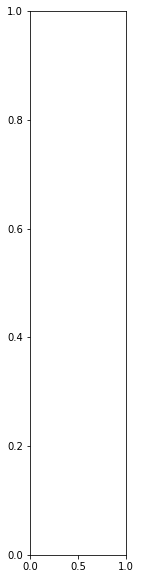

In [116]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

## Conclusions
This project taught us the basics of using PyTorch and pretrained neural networks for image recognition. We saw how to take a network that was trained on a large set of images and apply it successfully to a different task. Along the way, we learned a number of useful concepts for working with cnns in PyTorch including how to get our data into a model. The end result is a capable model trained in far less time than one trained from starting weights.

Some of the ideas covered in this notebook were:

* PyTorch basics
* Data transformations
* Training data augmentation
* Transfer Learning for object recognition
* Training a PyTorch model with early stopping on a validation set
* Inference using a PyTorch model

Truly, we live in an incredible age for deep learning with the wide availability of resources, and it's only getting better! Hopefully, this notebook has prepared you to take on your own deep learning challenges with PyTorch.